In [15]:
import csv
import matplotlib.pyplot as plt
import math
import numpy as np
import os


def iozone_dict(path):
    """Converts a csv containing iozone results to a dictionary."""
    with open(path + "/iozone.csv","r") as f:
        io_results = csv.reader(f)
        header = []
        header = next(io_results)
        data = dict.fromkeys(header)
        
        for h in data.keys():
            data[h] = []
        
        while 1:
            row = []
            try:
                row = next(io_results)
            except (AttributeError, StopIteration):
                break
            for i, v in enumerate(row):
                data[header[i]].append(row[i])
    return data

def dd_parse(l, path):
    """Converts csv files containing dd read or write results to a dictionary."""
    if l == "r":
        file = "/dd_reads.csv"
    elif l == "w":
        file = "/dd_writes.csv"
    else:
        return None
    
    with open(path + file, "r") as f:
        reads = csv.reader(f)
        results = next(reads)
        split_results = {2**i:0 for i in (7, 8, 9, 10)}
        
        i = 0
        while 1:
            if i+4 > len(results) - 1:
                break
            for j in range(4):
                split_results[2**(j+7)] += float(results[i+j])
            i += 4
        
        for k in split_results.keys():
        	n = split_results[k]
        	split_results[k] = n / 100

    return split_results

def hdparm_parse(l, path):
    """Takes a csv file containing hdparm buffered or cached read results and returns the average."""
    if l == "b":
        file = "/hdparm_buffered.csv"
    elif l == "c":
        file = "/hdparm_cached.csv"
    else:
        return None

    with open(path + file, "r") as f:
        reads = csv.reader(f)
        results = next(reads)
        results.remove("")
        f_results = [(lambda f: float(f))(i) for i in results]

    return sum(f_results) / len(f_results)

In [16]:
path = os.path.abspath("../all_results/25-01-24/littlefs") # placeholder: show first set of results

In [17]:
iozone_results = iozone_dict(path)

# independent variables: file size and record length
# taking base-2 logs for easier plotting
indices = [(lambda x, y: (int(math.log(int(x), 2)),int(math.log(int(y), 2))))(x, y) 
           for x, y in zip(iozone_results['kB'][:126], iozone_results['reclen'][:126])]

In [18]:
results = [[] for _ in range(13)]

for e, k in enumerate(list(iozone_results.keys())[2:15]):
    current = [[] for _ in range(126)]
    for i in range(126):
        for j in range(100):
            current[i].append(int(iozone_results[k][126*j + i]))  # groups results from different runs - every 126th line
    results[e] = [round(sum(a) / len(a)) for a in current]  # get average of 100 runs

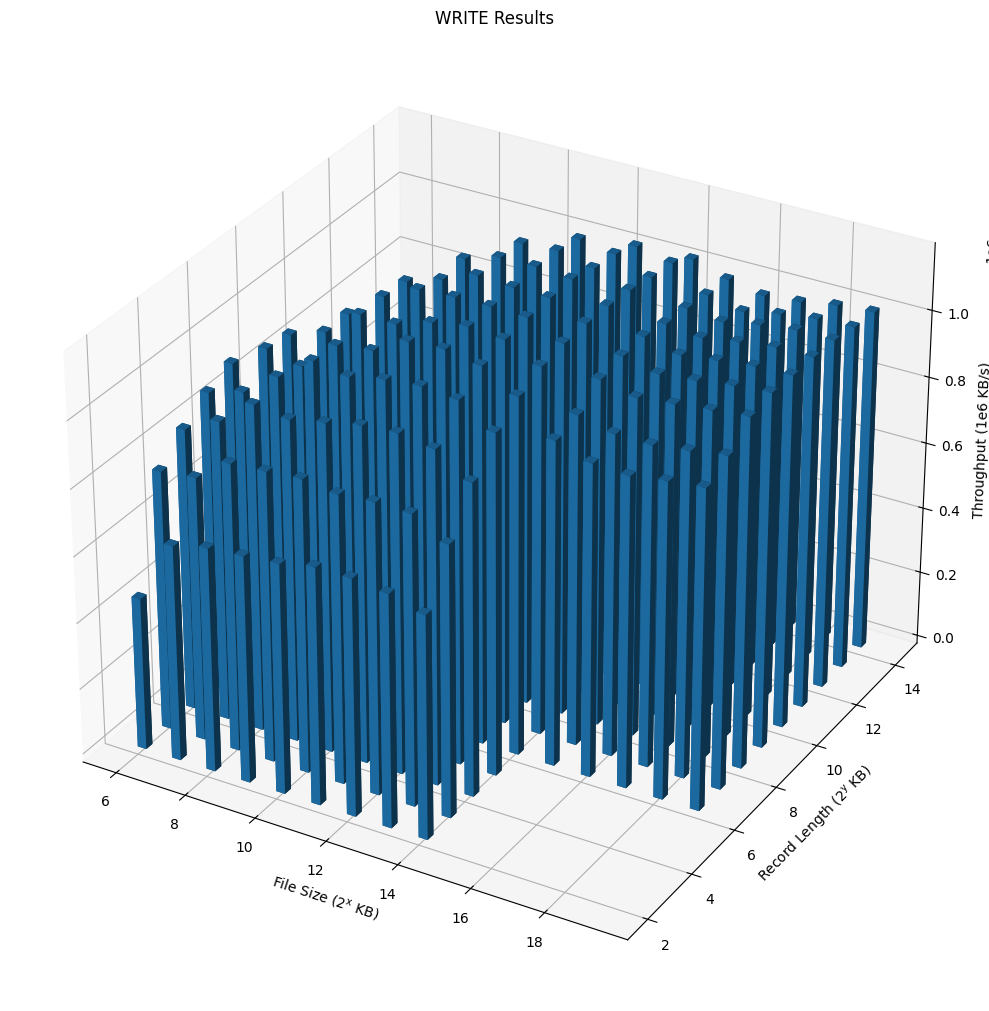

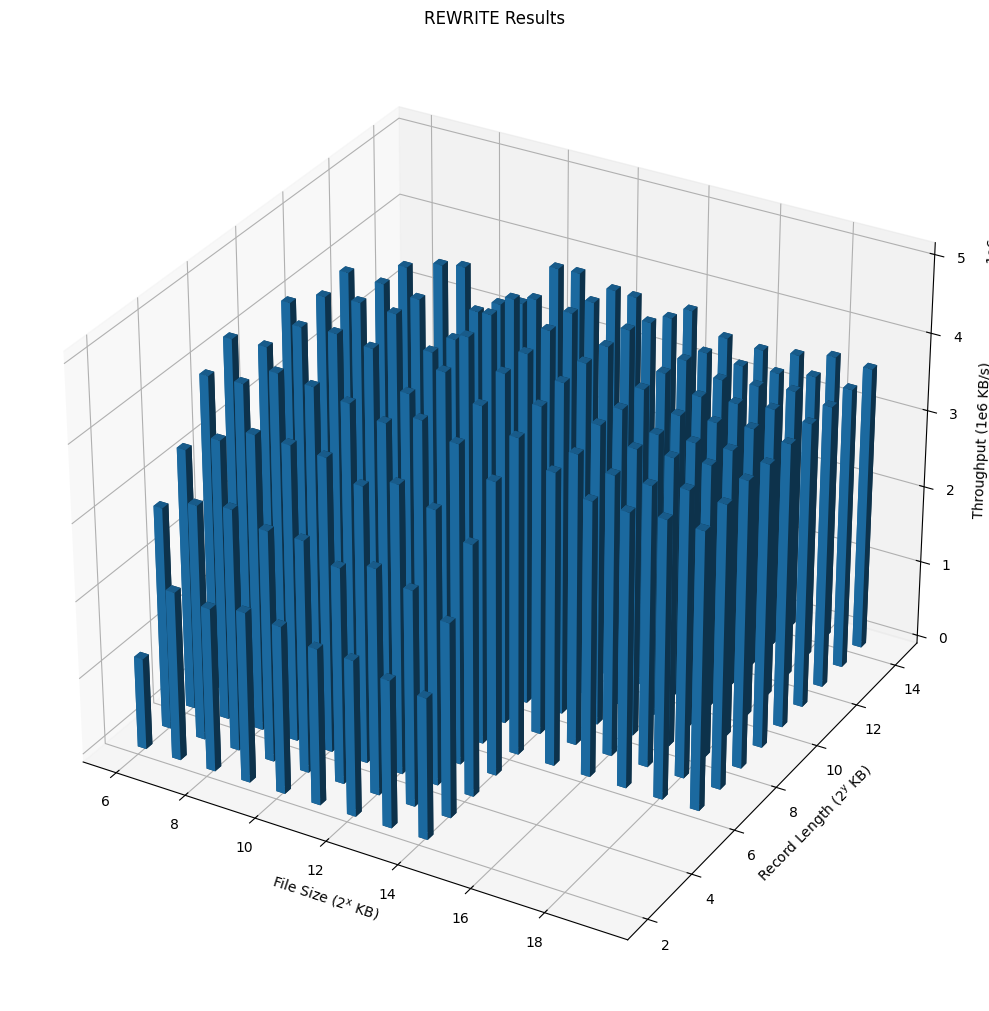

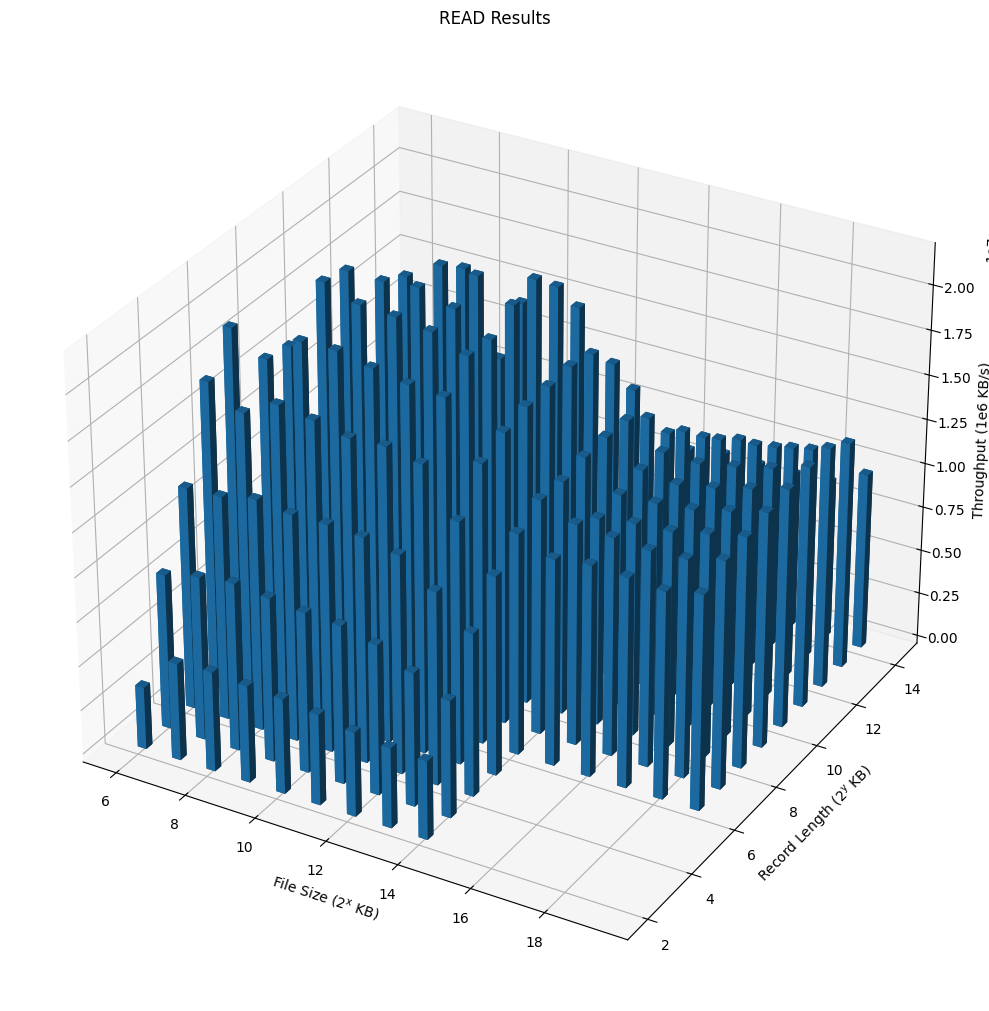

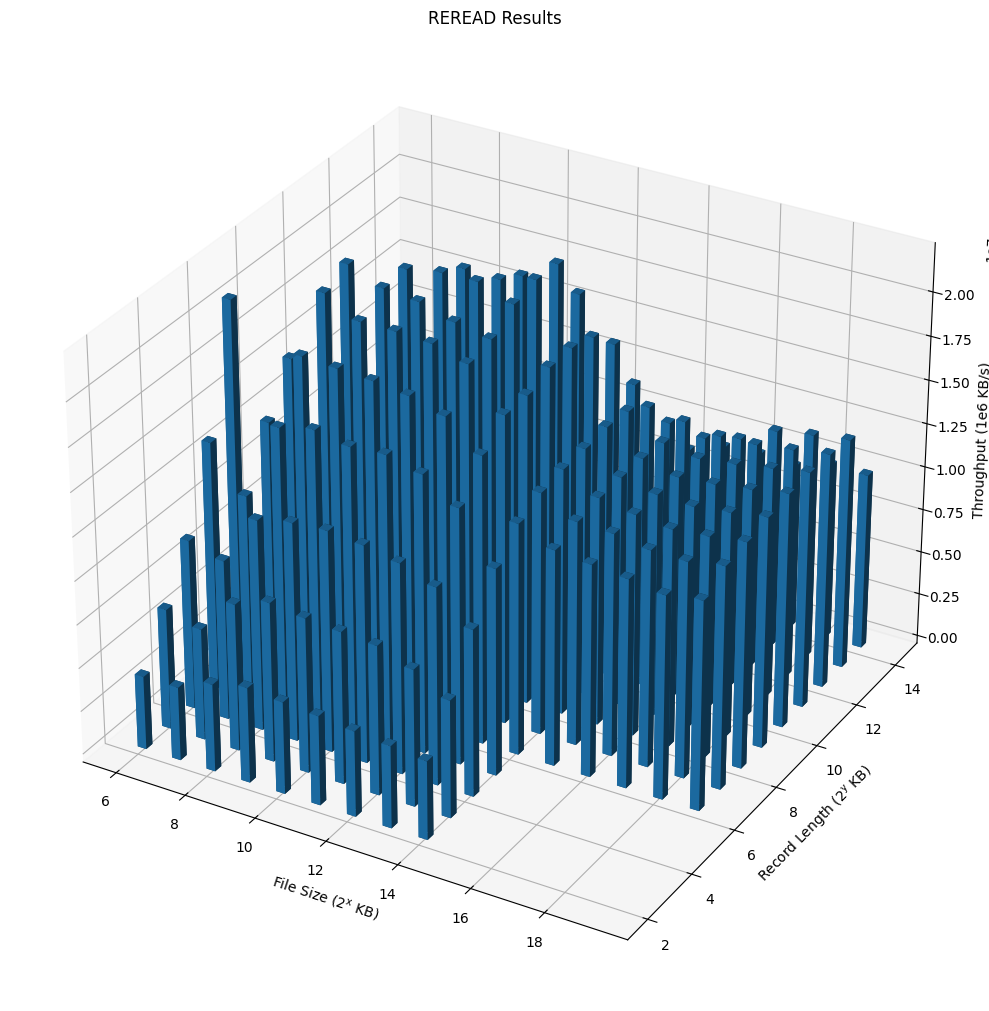

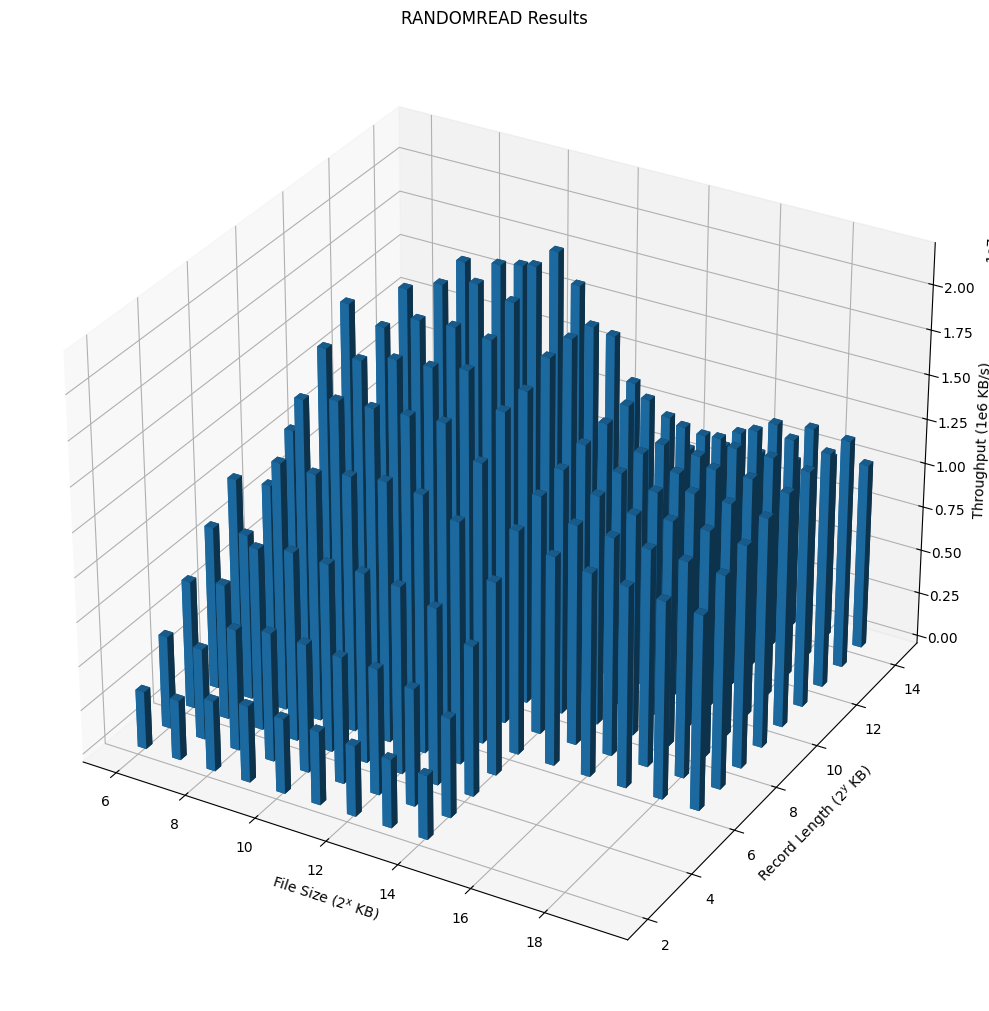

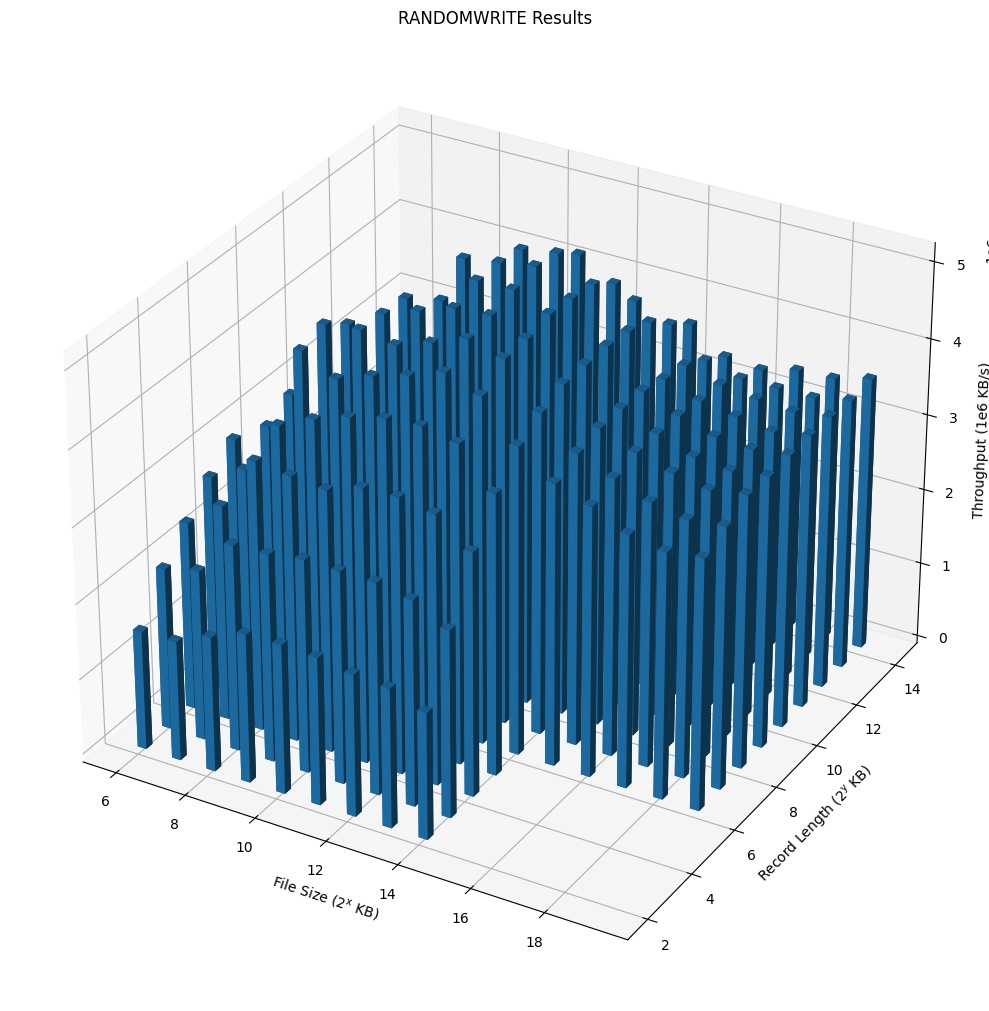

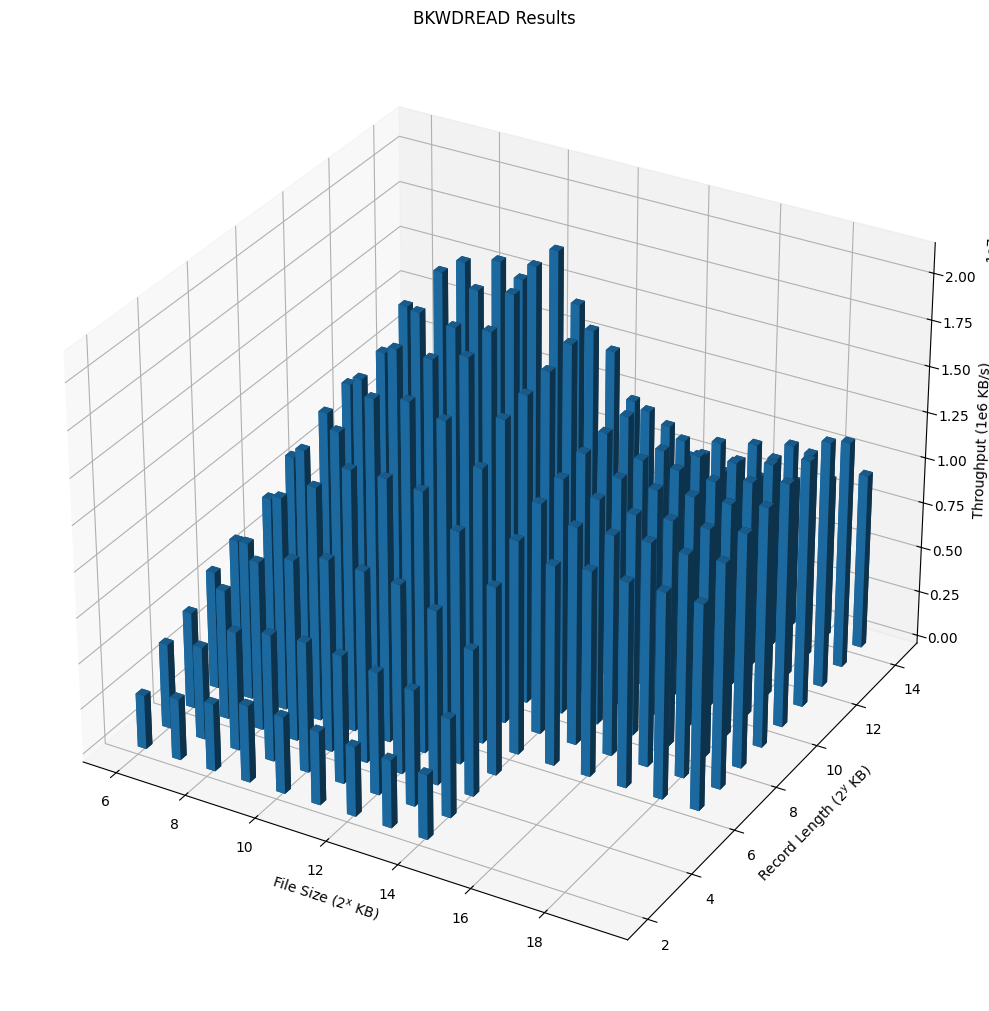

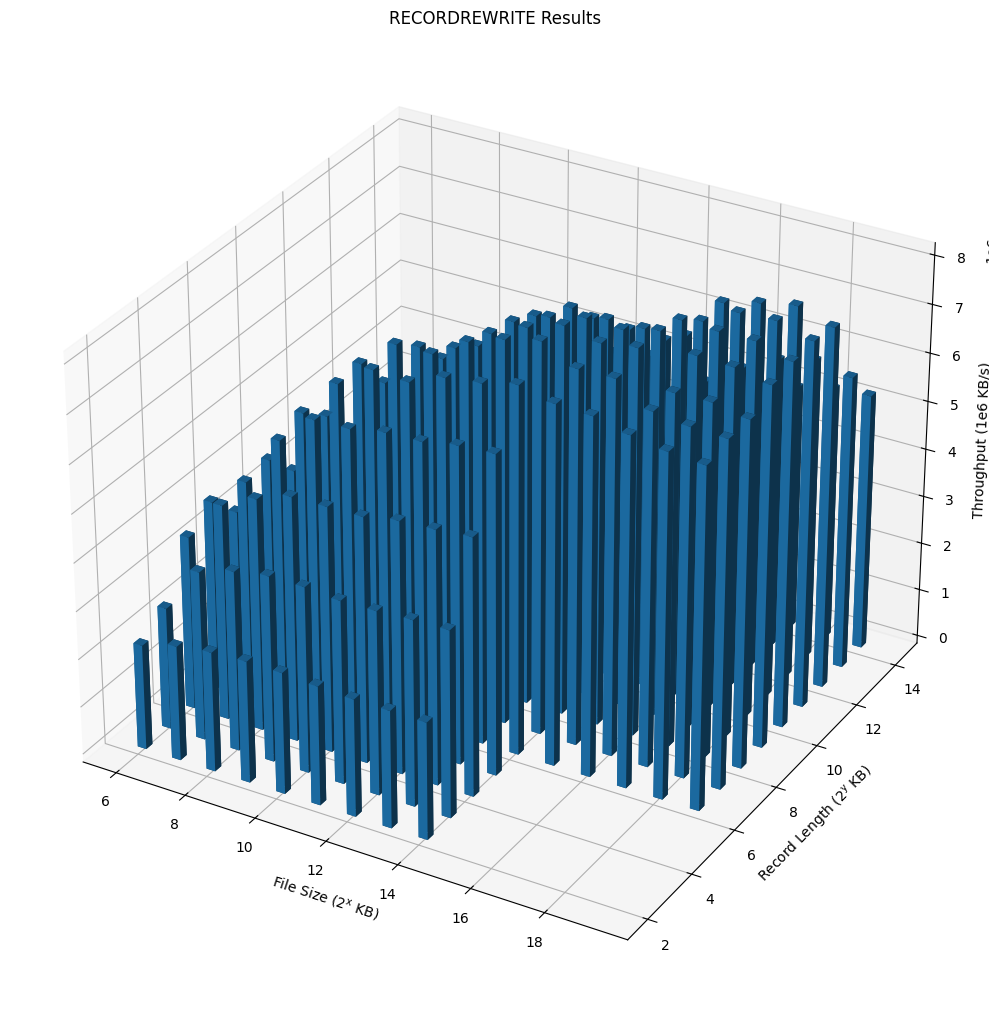

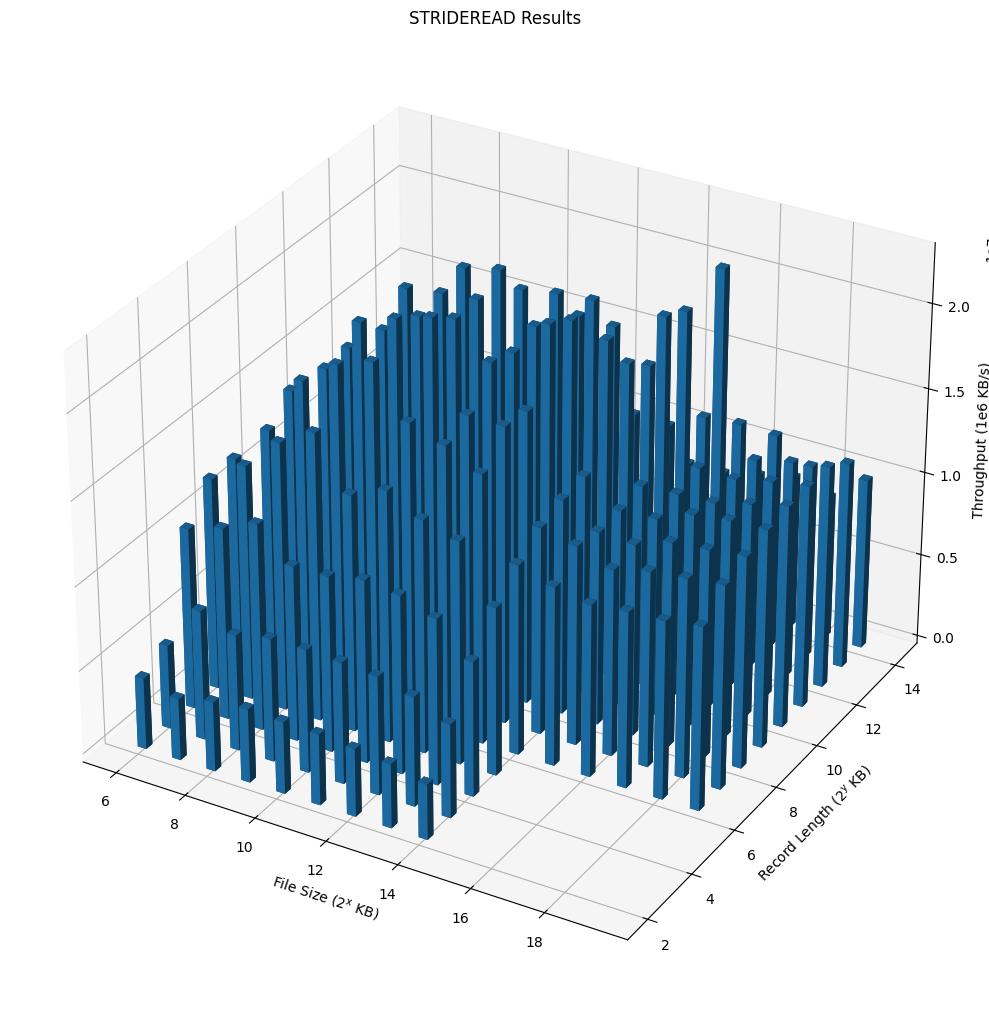

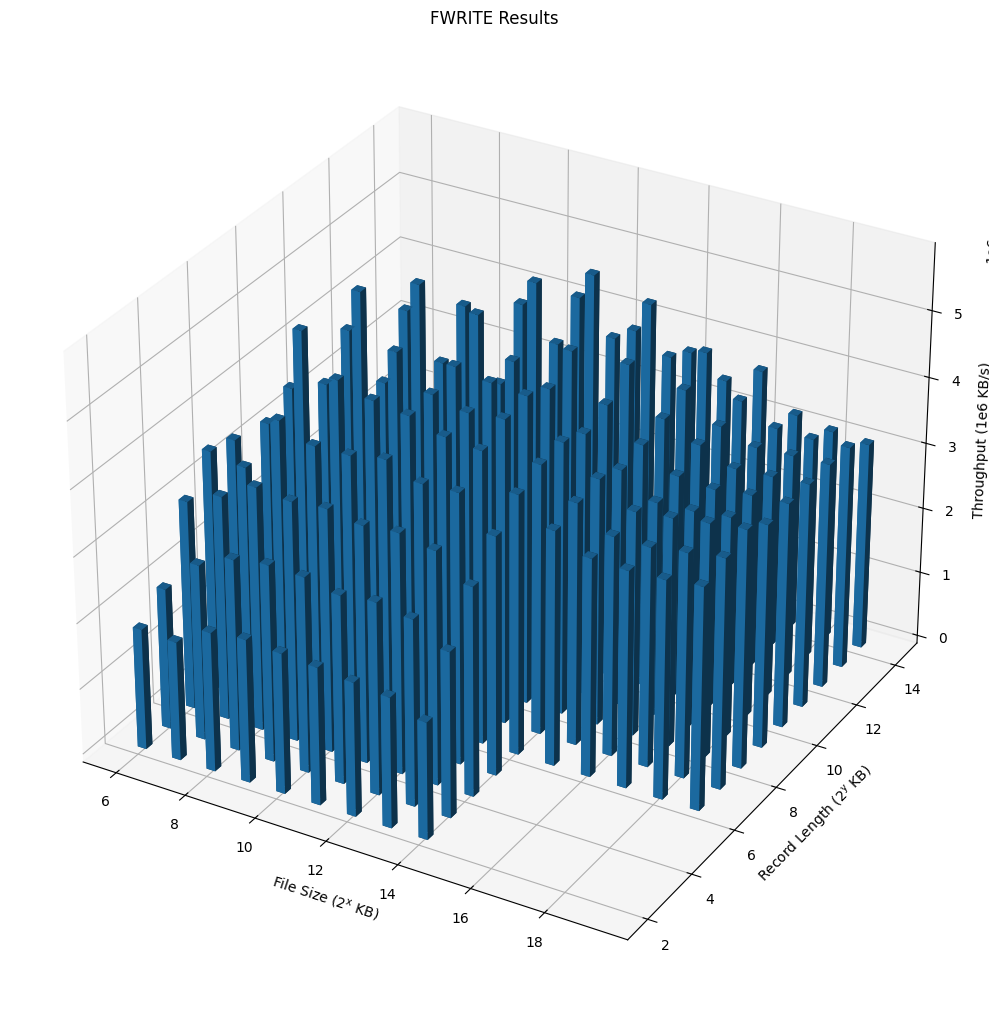

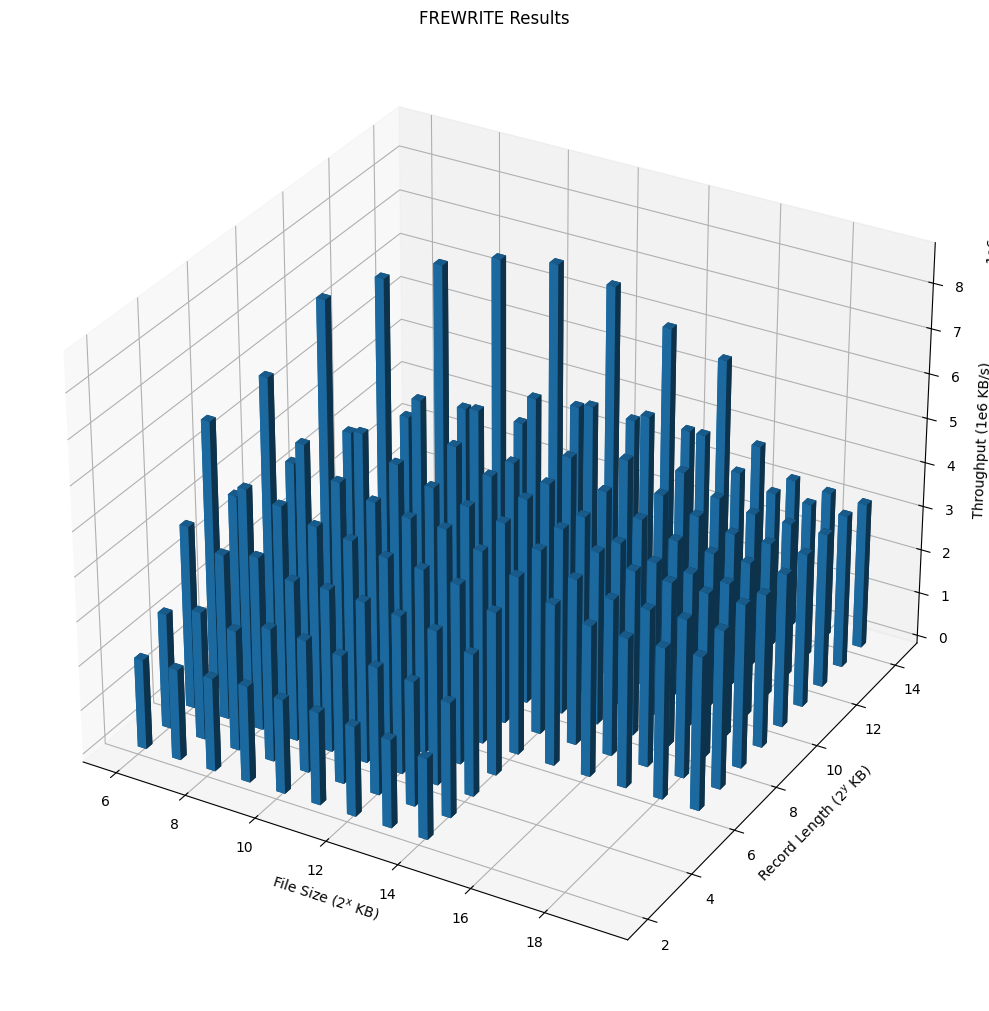

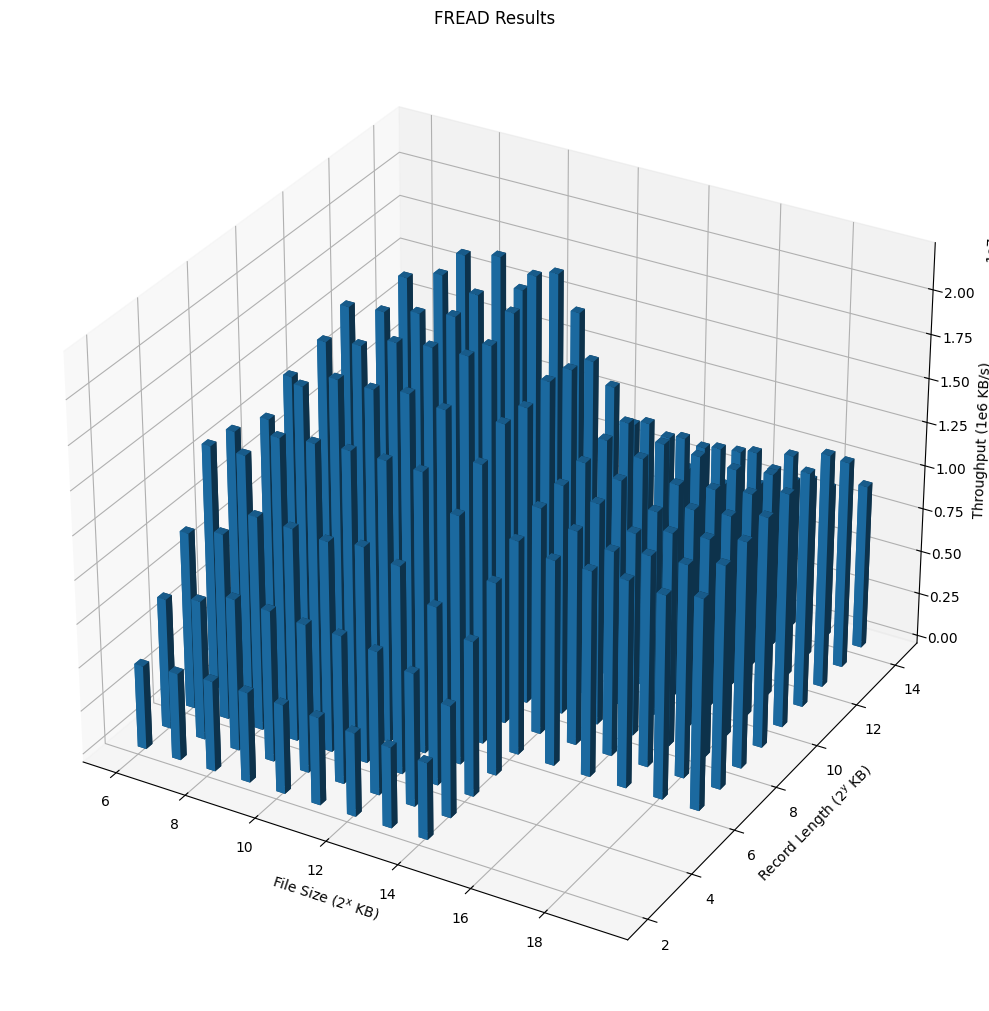

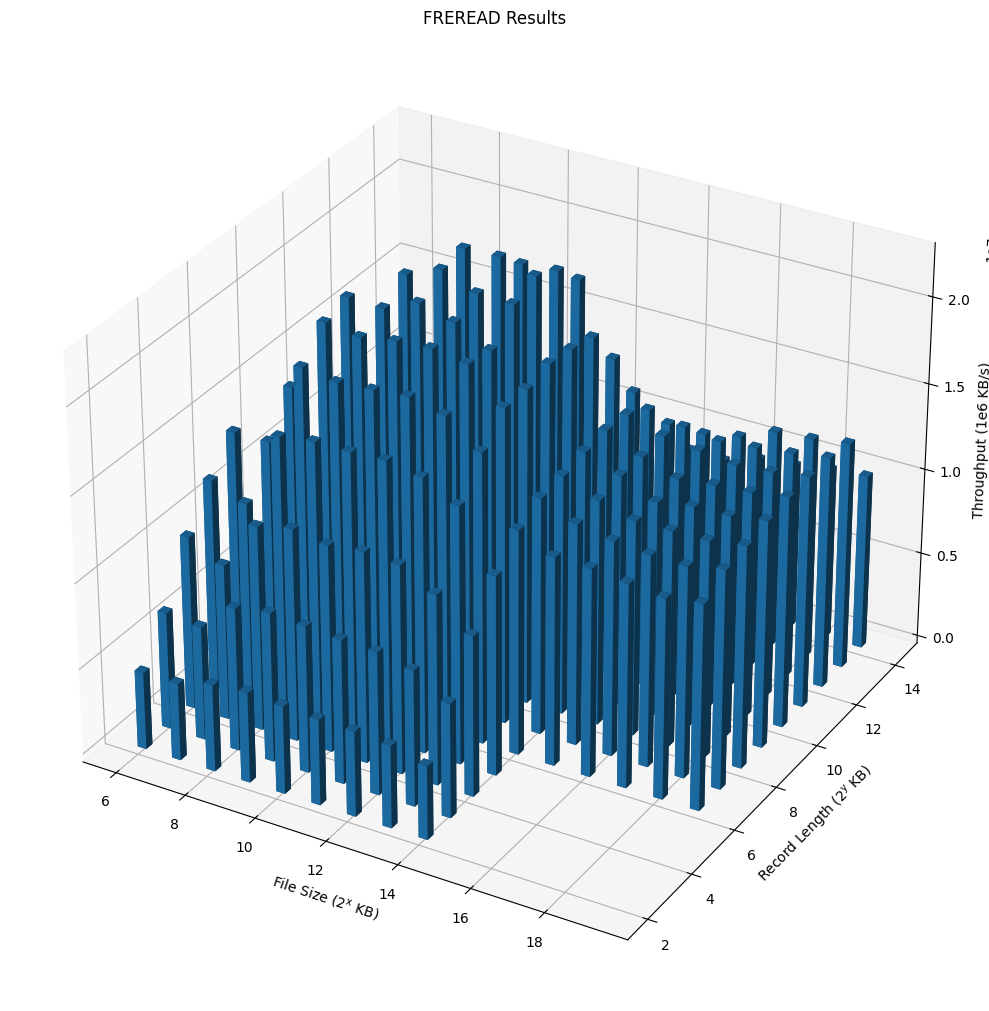

In [19]:
for e, k in enumerate(list(iozone_results.keys())[2:15]):
    points = np.array([[indices[i][0], indices[i][1], results[e][i]] for i in range(126)])
    x_vals = points[:,0]
    y_vals = points[:,1]
    z_vals = points[:,2]  # dz
    
    fig = plt.figure(figsize=(10,10), layout="constrained")
    ax = fig.add_subplot(111, projection="3d")
    
    dx = np.ones(126) * 0.25
    dy = np.ones(126) * 0.25
    
    ax.bar3d(x_vals, y_vals, np.zeros(126), dx, dy, z_vals)
    ax.set(zlabel="Throughput (1e6 KB/s)")
    
    plt.title("{} Results".format(k.upper()))
    plt.xlabel("File Size ($\mathregular{2^{x}}$ KB)")
    plt.ylabel("Record Length ($\mathregular{2^{y}}$ KB)")
    plt.show()

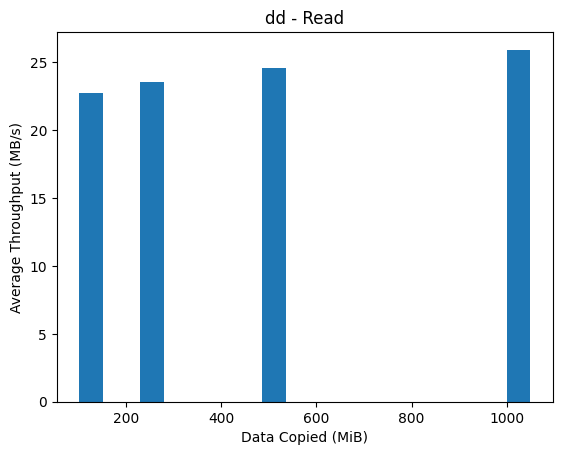

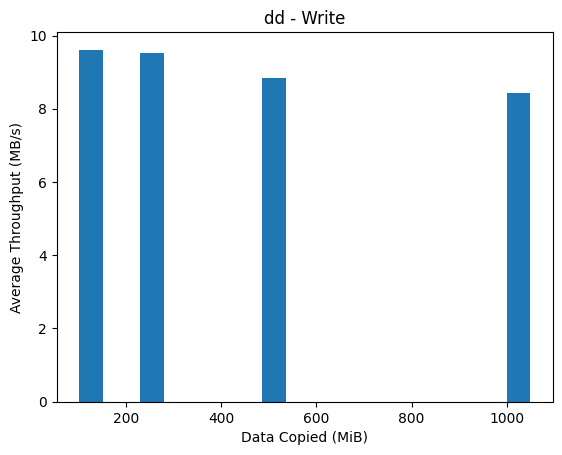

In [20]:
dd_reads = dd_parse("r", path)
dd_writes = dd_parse("w", path)
dd_labels = ("Read", "Write")

for i, d in enumerate((dd_reads, dd_writes)):
    plt.bar(list(d.keys()), list(d.values()), 50)
    plt.title("dd - {}".format(dd_labels[i]))
    plt.xlabel("Data Copied (MiB)")
    plt.ylabel("Average Throughput (MB/s)")
    plt.show()


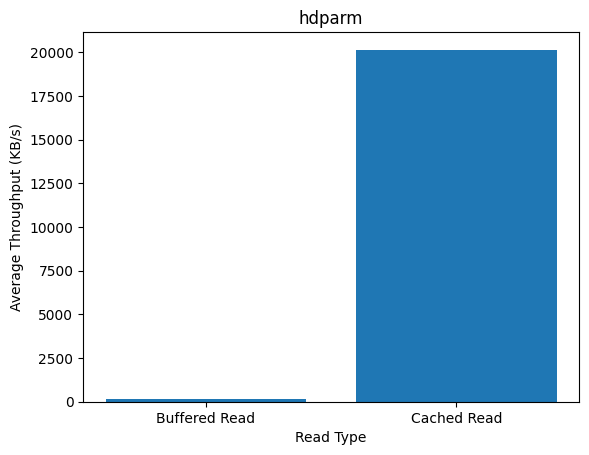

In [21]:
hdparm_vals = [hdparm_parse("b", path), hdparm_parse("c", path)]
hdparm_labels = ["Buffered Read", "Cached Read"]

plt.bar(hdparm_labels, hdparm_vals)
plt.title("hdparm")
plt.xlabel("Read Type")
plt.ylabel("Average Throughput (KB/s)")

plt.show()